This analysis was made by adapting [this](https://stmorse.github.io/journal/spotify-api.html) code.

In [2]:
import requests
from plotnine import *
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

CLIENT_ID = '7f3ea52b883c490ab91baeb2f7727db3'
CLIENT_SECRET = 'd07d15d1c8e141ccb0bd39fe62df5999'

/Users/luizfernandotoledo/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [4]:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

In [5]:
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Track ID from the URI
track_id = '5HZL0dCma3yL8r9LILJV8S'

# actual GET request with proper header
r = requests.get(BASE_URL + 'tracks/' + track_id, headers=headers)

In [6]:
r = r.json()
r

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6mdiAmATAx73kdxrNrnlao'},
    'href': 'https://api.spotify.com/v1/artists/6mdiAmATAx73kdxrNrnlao',
    'id': '6mdiAmATAx73kdxrNrnlao',
    'name': 'Iron Maiden',
    'type': 'artist',
    'uri': 'spotify:artist:6mdiAmATAx73kdxrNrnlao'}],
  'available_markets': ['AD',
   'AE',
   'AG',
   'AL',
   'AM',
   'AO',
   'AR',
   'AT',
   'AU',
   'AZ',
   'BA',
   'BB',
   'BD',
   'BE',
   'BF',
   'BG',
   'BH',
   'BI',
   'BJ',
   'BN',
   'BO',
   'BR',
   'BS',
   'BT',
   'BW',
   'BY',
   'BZ',
   'CA',
   'CD',
   'CG',
   'CH',
   'CI',
   'CL',
   'CM',
   'CO',
   'CR',
   'CV',
   'CW',
   'CY',
   'CZ',
   'DE',
   'DJ',
   'DK',
   'DM',
   'DO',
   'DZ',
   'EC',
   'EE',
   'EG',
   'ES',
   'FI',
   'FJ',
   'FM',
   'FR',
   'GA',
   'GB',
   'GD',
   'GE',
   'GH',
   'GM',
   'GN',
   'GQ',
   'GR',
   'GT',
   'GW',
   'GY',
   'HK',
   'HN',
   'HR',
   'HT',


In [7]:
# WE NEED TO MAKE TWO REQUESTS FOR THE API AS ITS LIMIT IS 50 AND THERE ARE 61 ALBUMS THERE.
# WE USE "OFFSET" FEATURE TO DO A FIRST REQUEST FROM ALBUM 0 TO 50 AND GET THE FIRST 50 ALBUMS, 
# THEM OFFSET 50 TO START FROM WHERE THE FIRST REQUEST ENDED.

artist_id = '6mdiAmATAx73kdxrNrnlao'

# pull all artists albums
r = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50, 'offset':0})
d = r.json()
r2 = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50, 'offset':50})
d2 = r2.json()
# d.update(d2)

In [8]:
# Let's group the first 50 albuns with the rest and get 61.

items = d['items'] + d2['items']
len(items)


61

In [9]:
# Check if we have every album
for album in items:
    print(album['name'], ' --- ', album['release_date'])

Senjutsu  ---  2021-09-03
Senjutsu  ---  2021-09-03
Nights of the Dead, Legacy of the Beast: Live in Mexico City  ---  2020-11-20
Nights of the Dead, Legacy of the Beast: Live in Mexico City  ---  2020-11-20
The Book of Souls: Live Chapter  ---  2017-11-17
The Book of Souls: The Live Chapter  ---  2017-11-17
The Book of Souls  ---  2015-09-04
The Book of Souls  ---  2015-09-04
Maiden England '88 (2013 Remaster)  ---  2013-03-25
En Vivo!  ---  2012-03-26
En Vivo! (Live at Estadio Nacional, Santiago)  ---  2012-03-23
En Vivo! (Live at Estadio Nacional, Santiago)  ---  2012-03-23
The Final Frontier (2015 - Remaster)  ---  2010-08-16
The Final Frontier (Deluxe Edition)  ---  2010-08-13
The Final Frontier  ---  2010-08-13
The Final Frontier (2015 Remaster)  ---  2010
Flight 666: The Original Soundtrack (Live)  ---  2009-06-09
Flight 666: The Original Soundtrack  ---  2009-05-25
A Matter of Life and Death (2015 - Remaster)  ---  2006-08-28
A Matter of Life and Death (2015 Remaster)  ---  200

In [10]:
# Creating a list of dictionaires that contains every song, audio features 
# OBS: popularity and song features are in different parts of the API, so we need to make two different requests.
# audio features like danceability were extracted from BASE_URL + audio_features/ + track id
# track popularity was extracted from BASE_URL + tracks/ + track_id)

data = []   # will hold all track info
albums = [] # to keep track of duplicates
track_info = []
# loop over albums and get all tracks
for album in items:
    album_name = album['name']
    # this takes a few seconds so let's keep track of progress    
    print(album_name)
    # pull all tracks from this album
    r = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
    tracks = r.json()['items']

    for track in tracks:
#         print(track['name'])
        # get audio features (key, liveness, danceability, ...)
        f = requests.get(BASE_URL + 'audio-features/' + track['id'], 
            headers=headers)
        f2 = requests.get(BASE_URL + 'tracks/' + track['id'], 
            headers=headers)
        f = f.json()
        f2 = f2.json()
        print('song name:' + track['name'] + ' and popularity: '+ str(f2['popularity']))
#         print(f'a')
        my_object = {
            "name": track['name'],
            "popularity": f2["popularity"],
            'release_date': f2['album']['release_date'],
            "valence": f["valence"],
            "danceability": f['danceability'],
            "energy": f['energy'],
            "danceability": f['danceability'],
            "key": f['key'],
            "loudness": f['loudness'],
            "mode": f['mode'],
            "speechiness": f['speechiness'],
            "danceability": f['danceability'],
            "acousticness": f['acousticness'],
            "instrumentalness": f['instrumentalness'],
            "liveness": f['liveness'],
            "tempo": f['tempo'],
            "duration_ms": f['duration_ms'],
            "danceability": f['danceability']
                    }
  
        track_info.append(my_object)
#         data.append(f)
track_info
break


      # combine with album info
#         f.update({
#             'track_name': track['name'],
#             'album_name': album_name,
# #             'short_album_name': trim_name,
# #             'release_date': album['release_date'],
#             'album_id': album['id']
#         })

Senjutsu
song name:Senjutsu and popularity: 43
song name:Stratego and popularity: 44
song name:The Writing On The Wall and popularity: 49
song name:Lost In A Lost World and popularity: 41
song name:Days Of Future Past and popularity: 46
song name:The Time Machine and popularity: 40
song name:Darkest Hour and popularity: 40
song name:Death Of The Celts and popularity: 38
song name:The Parchment and popularity: 40
song name:Hell On Earth and popularity: 40
Senjutsu
song name:Senjutsu and popularity: 57
song name:Stratego and popularity: 57
song name:The Writing On The Wall and popularity: 63
song name:Lost In A Lost World and popularity: 56
song name:Days Of Future Past and popularity: 59
song name:The Time Machine and popularity: 54
song name:Darkest Hour and popularity: 54
song name:Death Of The Celts and popularity: 53
song name:The Parchment and popularity: 54
song name:Hell On Earth and popularity: 54
Nights of the Dead, Legacy of the Beast: Live in Mexico City
song name:Churchill’s

song name:Wasted Years - Live at HSBC Arena, Rio De Janeiro, Brazil - 17th March 2016 and popularity: 16
The Book of Souls
song name:If Eternity Should Fail and popularity: 33
song name:Speed of Light and popularity: 39
song name:The Great Unknown and popularity: 27
song name:The Red and the Black and popularity: 36
song name:When the River Runs Deep and popularity: 26
song name:The Book of Souls and popularity: 30
song name:Death or Glory and popularity: 28
song name:Shadows of the Valley and popularity: 26
song name:Tears of a Clown and popularity: 29
song name:The Man of Sorrows and popularity: 25
song name:Empire of the Clouds and popularity: 31
The Book of Souls
song name:If Eternity Should Fail and popularity: 45
song name:Speed of Light and popularity: 52
song name:The Great Unknown and popularity: 40
song name:The Red and the Black and popularity: 49
song name:When the River Runs Deep and popularity: 38
song name:The Book of Souls and popularity: 43
song name:Death or Glory and

song name:The Man Who Would Be King and popularity: 0
song name:When The Wild Wind Blows and popularity: 0
The Final Frontier
song name:Satellite 15 and popularity: 7
song name:El Dorado and popularity: 8
song name:Mother Of Mercy and popularity: 5
song name:Coming Home and popularity: 14
song name:The Alchemist and popularity: 6
song name:Isle Of Avalon and popularity: 5
song name:Starblind and popularity: 5
song name:The Talisman and popularity: 7
song name:The Man Who Would Be King and popularity: 5
song name:When The Wild Wind Blows and popularity: 10
The Final Frontier (2015 Remaster)
song name:Satellite 15.....The Final Frontier - 2015 Remaster and popularity: 39
song name:El Dorado - 2015 Remaster and popularity: 40
song name:Mother of Mercy - 2015 Remaster and popularity: 37
song name:Coming Home - 2015 Remaster and popularity: 44
song name:The Alchemist - 2015 Remaster and popularity: 37
song name:Isle of Avalon - 2015 Remaster and popularity: 35
song name:Starblind - 2015 Rem

song name:Journeyman - 2015 Remaster and popularity: 27
Dance of Death (2015 Remaster)
song name:Wildest Dreams - 2015 Remaster and popularity: 39
song name:Rainmaker - 2015 Remaster and popularity: 46
song name:No More Lies - 2015 Remaster and popularity: 44
song name:Montségur - 2015 Remaster and popularity: 39
song name:Dance of Death - 2015 Remaster and popularity: 56
song name:Gates of Tomorrow - 2015 Remaster and popularity: 37
song name:New Frontier - 2015 Remaster and popularity: 37
song name:Paschendale - 2015 Remaster and popularity: 44
song name:Face in the Sand - 2015 Remaster and popularity: 38
song name:Age of Innocence - 2015 Remaster and popularity: 35
song name:Journeyman - 2015 Remaster and popularity: 46
BBC Archives (Live)
song name:Iron Maiden - Live: Radio 1 Rock Show, 14 November 1979 and popularity: 10
song name:Running Free - Live: Radio 1 Rock Show, 14 November 1979 and popularity: 9
song name:Transylvania - Live: Radio 1 Rock Show, 14 November 1979 and popula

song name:Brave New World - Live '01 and popularity: 39
song name:Wrathchild - Live '01 and popularity: 38
song name:2 Minutes To Midnight - Live '01 and popularity: 39
song name:Blood Brothers - Live '01 and popularity: 39
song name:Sign of the Cross - Live At Rock in Rio '01 and popularity: 40
song name:The Mercenary - Live '01 and popularity: 35
song name:The Trooper - Live '01 and popularity: 40
song name:Dream Of Mirrors - Live '01 and popularity: 37
song name:The Clansman - Live At Rock in Rio '01 and popularity: 41
song name:The Evil That Men Do - Live '01 and popularity: 38
song name:Fear of the Dark - Live '01 and popularity: 51
song name:Iron Maiden - Live '01 and popularity: 34
song name:The Number Of The Beast - Live '01 and popularity: 37
song name:Hallowed Be Thy Name - Live '01 and popularity: 40
song name:Sanctuary - Live '01 and popularity: 32
song name:Run To The Hills - Live '01 and popularity: 39
Brave New World (2015 - Remaster)
song name:The Wicker Man - 2015 Rema

song name:Wrathchild - Live at Donington; 1998 Remaster and popularity: 23
song name:From Here to Eternity - Live at Donington; 1998 Remaster and popularity: 23
song name:Can I Play With Madness - Live at Donington; 1998 Remaster and popularity: 22
song name:Wasting Love - Live at Donington; 1998 Remaster and popularity: 25
song name:Tailgunner - Live at Donington; 1998 Remaster and popularity: 22
song name:The Evil That Men Do - Live at Donington; 1998 Remaster and popularity: 23
song name:Afraid To Shoot Strangers - Live at Donington; 1998 Remaster and popularity: 25
song name:Fear Of The Dark - Live at Donington; 1998 Remaster and popularity: 27
song name:Bring Your Daughter...To The Slaughter - Live at Donington; 1998 Remaster and popularity: 25
song name:The Clairvoyant - Live at Donington; 1998 Remaster and popularity: 22
song name:Heaven Can Wait - Live at Donington; 1998 Remaster and popularity: 21
song name:Run To The Hills - Live at Donington; 1998 Remaster and popularity: 22

song name:Sanctuary - Live at Birmingham NEC, 1988; 2013 Remaster and popularity: 18
Seventh Son of a Seventh Son (2015 Remaster)
song name:Moonchild - 2015 Remaster and popularity: 50
song name:Infinite Dreams - 2015 Remaster and popularity: 48
song name:Can I Play with Madness - 2015 Remaster and popularity: 58
song name:The Evil That Men Do - 2015 Remaster and popularity: 57
song name:Seventh Son of a Seventh Son - 2015 Remaster and popularity: 53
song name:The Prophecy - 2015 Remaster and popularity: 44
song name:The Clairvoyant - 2015 Remaster and popularity: 48
song name:Only the Good Die Young - 2015 Remaster and popularity: 46
Somewhere in Time (2015 - Remaster)
song name:Caught Somewhere in Time - 2015 Remaster and popularity: 42
song name:Wasted Years - 2015 Remaster and popularity: 55
song name:Sea of Madness - 2015 Remaster and popularity: 35
song name:Heaven Can Wait - 2015 Remaster and popularity: 36
song name:The Loneliness of the Long Distance Runner - 2015 Remaster and

song name:Run to the Hills - 2015 Remaster and popularity: 72
song name:Gangland - 2015 Remaster and popularity: 45
song name:Hallowed Be Thy Name - 2015 Remaster and popularity: 67
Killers (2015 - Remaster)
song name:The Ides of March - 2015 Remaster and popularity: 34
song name:Wrathchild - 2015 Remaster and popularity: 44
song name:Murders in the Rue Morgue - 2015 Remaster and popularity: 37
song name:Another Life - 2015 Remaster and popularity: 33
song name:Genghis Khan - 2015 Remaster and popularity: 34
song name:Innocent Exile - 2015 Remaster and popularity: 32
song name:Killers - 2015 Remaster and popularity: 41
song name:Prodigal Son - 2015 Remaster and popularity: 32
song name:Purgatory - 2015 Remaster and popularity: 34
song name:Drifter - 2015 Remaster and popularity: 31
Killers (2015 Remaster)
song name:The Ides of March - 2015 Remaster and popularity: 42
song name:Wrathchild - 2015 Remaster and popularity: 52
song name:Murders in the Rue Morgue - 2015 Remaster and populari

SyntaxError: 'break' outside loop (2264344106.py, line 54)

In [11]:
track_info

[{'name': 'Senjutsu',
  'popularity': 43,
  'release_date': '2021-09-03',
  'valence': 0.466,
  'danceability': 0.347,
  'energy': 0.885,
  'key': 9,
  'loudness': -6.121,
  'mode': 0,
  'speechiness': 0.0615,
  'acousticness': 0.000171,
  'instrumentalness': 0.0892,
  'liveness': 0.217,
  'tempo': 180.172,
  'duration_ms': 500171},
 {'name': 'Stratego',
  'popularity': 44,
  'release_date': '2021-09-03',
  'valence': 0.465,
  'danceability': 0.473,
  'energy': 0.968,
  'key': 4,
  'loudness': -7.297,
  'mode': 0,
  'speechiness': 0.0642,
  'acousticness': 0.000144,
  'instrumentalness': 0.0347,
  'liveness': 0.612,
  'tempo': 138.054,
  'duration_ms': 299946},
 {'name': 'The Writing On The Wall',
  'popularity': 49,
  'release_date': '2021-09-03',
  'valence': 0.566,
  'danceability': 0.402,
  'energy': 0.912,
  'key': 2,
  'loudness': -5.447,
  'mode': 0,
  'speechiness': 0.0442,
  'acousticness': 0.00158,
  'instrumentalness': 0.000179,
  'liveness': 0.0923,
  'tempo': 90.045,
  'du

In [12]:
# turn everything into a single table
import pandas as pd

df = pd.DataFrame(track_info)
len(df)

791

In [13]:
#remove duplicates (ignoring lives)
print(len(df))
final_df = df.sort_values('popularity', ascending=False).drop_duplicates('name').sort_index()
print(len(final_df))

791
423


In [14]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 10 to 790
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              423 non-null    object 
 1   popularity        423 non-null    int64  
 2   release_date      423 non-null    object 
 3   valence           423 non-null    float64
 4   danceability      423 non-null    float64
 5   energy            423 non-null    float64
 6   key               423 non-null    int64  
 7   loudness          423 non-null    float64
 8   mode              423 non-null    int64  
 9   speechiness       423 non-null    float64
 10  acousticness      423 non-null    float64
 11  instrumentalness  423 non-null    float64
 12  liveness          423 non-null    float64
 13  tempo             423 non-null    float64
 14  duration_ms       423 non-null    int64  
dtypes: float64(9), int64(4), object(2)
memory usage: 52.9+ KB


In [15]:
# how the dataframe looks like
final_df.head(5)

,name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms
10,Senjutsu,57,2021-09-03,0.466,0.347,0.885,9,-6.121,0,0.0615,0.000171,0.089200,0.2170,180.172,500171
11,Stratego,57,2021-09-03,0.465,0.473,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946
12,The Writing On The Wall,63,2021-09-03,0.566,0.402,0.912,2,-5.447,0,0.0442,0.001580,0.000179,0.0923,90.045,373899
13,Lost In A Lost World,56,2021-09-03,0.206,0.251,0.871,4,-6.414,0,0.0871,0.004070,0.007510,0.1080,92.975,571584
14,Days Of Future Past,59,2021-09-03,0.476,0.433,0.920,4,-4.738,0,0.0409,0.000576,0.000055,0.1230,92.466,243755


In [16]:
# fix the release_date column
final_df.release_date = pd.to_datetime(final_df.release_date)
final_df['year'] = pd.DatetimeIndex(final_df['release_date']).year
final_df.head(1)

,name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year
10,Senjutsu,57,2021-09-03,0.466,0.347,0.885,9,-6.121,0,0.0615,0.000171,0.0892,0.217,180.172,500171,2021


In [17]:
# save to csv
final_df.to_csv('discography.csv', index=False)


In [18]:
# remove "live" names
final_df['simple_name'] = final_df['name'].apply(lambda x: x.split('-')[0])
final_df

,name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year,simple_name
10,Senjutsu,57,2021-09-03,0.466,0.347,0.885,9,-6.121,0,0.0615,0.000171,0.089200,0.2170,180.172,500171,2021,Senjutsu
11,Stratego,57,2021-09-03,0.465,0.473,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946,2021,Stratego
12,The Writing On The Wall,63,2021-09-03,0.566,0.402,0.912,2,-5.447,0,0.0442,0.001580,0.000179,0.0923,90.045,373899,2021,The Writing On The Wall
13,Lost In A Lost World,56,2021-09-03,0.206,0.251,0.871,4,-6.414,0,0.0871,0.004070,0.007510,0.1080,92.975,571584,2021,Lost In A Lost World
14,Days Of Future Past,59,2021-09-03,0.476,0.433,0.920,4,-4.738,0,0.0409,0.000576,0.000055,0.1230,92.466,243755,2021,Days Of Future Past
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,Phantom of the Opera - 2015 Remaster,59,1980-01-01,0.228,0.319,0.952,4,-5.315,0,0.0723,0.000063,0.154000,0.9180,109.275,441467,1980,Phantom of the Opera
787,Transylvania - 2015 Remaster,51,1980-01-01,0.214,0.221,0.983,0,-3.204,1,0.1500,0.000927,0.971000,0.8810,107.260,244853,1980,Transylvania
788,Strange World - 2015 Remaster,46,1980-01-01,0.194,0.360,0.538,4,-7.334,0,0.0324,0.019300,0.051800,0.3640,125.683,347347,1980,Strange World
789,Charlotte the Harlot - 2015 Remaster,42,1980-01-01,0.463,0.358,0.958,0,-4.117,1,0.1330,0.010400,0.000008,0.4060,106.922,253053,1980,Charlotte the Harlot


In [19]:
#remove duplicates with new names
print(len(final_df))
unique_df = final_df.sort_values('popularity', ascending=False).drop_duplicates('simple_name').sort_index()
print(len(unique_df))

423
206


In [20]:
# fixing the song names by removing live, concert, etc
unique_df.name = unique_df.simple_name
unique_df.head(3)

,name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year,simple_name
10,Senjutsu,57,2021-09-03,0.466,0.347,0.885,9,-6.121,0,0.0615,0.000171,0.089200,0.2170,180.172,500171,2021,Senjutsu
11,Stratego,57,2021-09-03,0.465,0.473,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946,2021,Stratego
12,The Writing On The Wall,63,2021-09-03,0.566,0.402,0.912,2,-5.447,0,0.0442,0.001580,0.000179,0.0923,90.045,373899,2021,The Writing On The Wall


In [21]:
# remove duplicates based on lower and upper case, keeping the most popular
unique_df['uniques'] = unique_df.name.str.lower()
unique_df

print(len(unique_df))
maiden_final = unique_df.sort_values('popularity', ascending=False).drop_duplicates('uniques').sort_index()
print(len(maiden_final))

206
189


In [22]:
maiden_final.valence.mean()

0.36537248677248674

In [23]:
maiden_final.sort_values(by='valence', ascending=False).head(10)

,name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year,simple_name,uniques
766,Wrathchild,52,1981-01-01,0.782,0.438,0.930,9,-4.959,1,0.0484,0.018800,0.349000,0.1960,104.812,175053,1981,Wrathchild,wrathchild
785,Running Free,52,1980-01-01,0.764,0.478,0.823,11,-5.346,0,0.2060,0.000777,0.229000,0.1690,171.263,197573,1980,Running Free,running free
597,Weekend Warrior,41,1992-01-01,0.759,0.359,0.938,7,-4.606,1,0.0682,0.007070,0.000000,0.2960,135.054,339493,1992,Weekend Warrior,weekend warrior
713,Aces High,63,1984-01-01,0.756,0.300,0.936,2,-5.399,1,0.0456,0.033700,0.021000,0.1580,133.065,271907,1984,Aces High,aces high
465,Futureal,41,1998-01-01,0.706,0.398,0.990,4,-3.208,0,0.0841,0.006100,0.002920,0.3140,99.785,175120,1998,Futureal,futureal
595,The Apparition,40,1992-01-01,0.693,0.592,0.929,9,-4.281,1,0.0378,0.000985,0.000095,0.0777,98.092,234787,1992,The Apparition,the apparition
747,Invaders,48,1982-01-01,0.684,0.439,0.937,4,-5.410,0,0.0493,0.017500,0.025200,0.4960,111.794,203387,1982,Invaders,invaders
734,The Trooper,74,1983-01-01,0.669,0.285,0.908,4,-4.601,0,0.0705,0.031800,0.009090,0.3110,159.756,252733,1983,The Trooper,the trooper
768,Another Life,41,1981-01-01,0.666,0.201,0.959,2,-5.130,1,0.1400,0.001130,0.422000,0.1770,184.314,203507,1981,Another Life,another life
646,Infinite Dreams,48,1988-01-01,0.659,0.196,0.962,4,-4.533,0,0.0955,0.026900,0.000044,0.1480,78.783,369373,1988,Infinite Dreams,infinite dreams


In [24]:
pd.set_option('display.max_rows', None)
# select only name and valence columns

name_valence = unique_df[["name", "valence"]]
name_valence

name_valence.to_csv('name_valence.csv', index=False)
name_valence

,name,valence
10,Senjutsu,0.4660
11,Stratego,0.4650
12,The Writing On The Wall,0.5660
13,Lost In A Lost World,0.2060
14,Days Of Future Past,0.4760
15,The Time Machine,0.3160
16,Darkest Hour,0.1620
17,Death Of The Celts,0.2600
18,The Parchment,0.2120
19,Hell On Earth,0.0628


In [25]:
pd.set_option('display.max_rows', None)
# select only name and valence columns

name_valence_popularity = unique_df[["name", "valence", 'popularity']]
name_valence_popularity

name_valence_popularity.to_csv('name_valence_popularity.csv', index=False)
name_valence_popularity

,name,valence,popularity
10,Senjutsu,0.4660,57
11,Stratego,0.4650,57
12,The Writing On The Wall,0.5660,63
13,Lost In A Lost World,0.2060,56
14,Days Of Future Past,0.4760,59
15,The Time Machine,0.3160,54
16,Darkest Hour,0.1620,54
17,Death Of The Celts,0.2600,53
18,The Parchment,0.2120,54
19,Hell On Earth,0.0628,54


In [26]:
# is there a correlation between popularity and valence?
import statsmodels.formula.api as smf

model = smf.ols("valence ~ popularity", data=name_valence_popularity)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     13.72
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           0.000273
Time:                        12:06:54   Log-Likelihood:                 70.139
No. Observations:                 206   AIC:                            -136.3
Df Residuals:                     204   BIC:                            -129.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2054      0.041      4.962      0.000       0.124       0.287
popularity     0.0035      0.001      3.705      0.000       0.002       0.005
==============================================================================
Omnibus:                       18.992   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.906
Skew:                           0.301   Prob(JB):                       0.0116
Kurtosis:                       2.178   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# No, there isn't. But maybe we could tell it in a different way. How happy are their 10 most popular songs?

name_valence_popularity.sort_values('popularity', ascending=False)



,name,valence,popularity
734,The Trooper,0.6690,74
752,Run to the Hills,0.4580,72
598,Fear of the Dark,0.2270,72
751,The Number of the Beast,0.2680,69
754,Hallowed Be Thy Name,0.3000,67
662,Wasted Years,0.4920,66
592,Wasting Love,0.2900,66
714,2 Minutes to Midnight,0.5950,66
12,The Writing On The Wall,0.5660,63
713,Aces High,0.7560,63


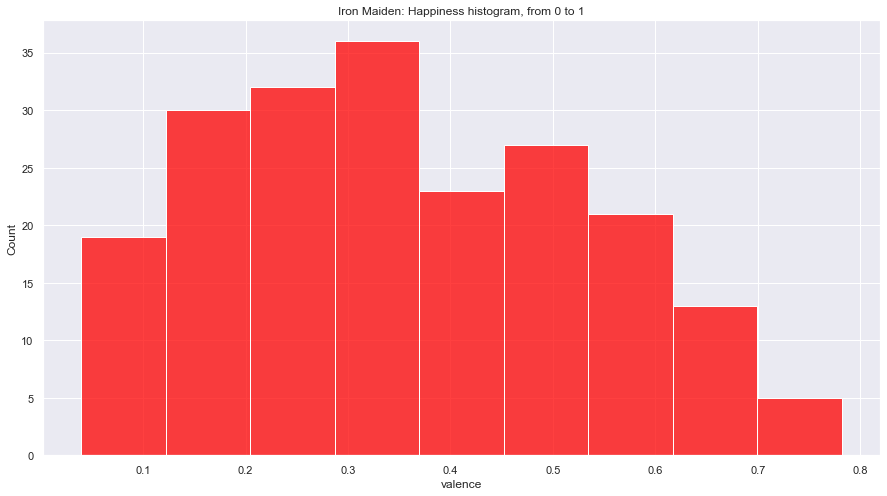

In [29]:
# valence histogram

sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=name_valence, x = 'valence', color='red').set(title='Iron Maiden: Happiness histogram, from 0 to 1')
plt.savefig('valence_histogram.png')


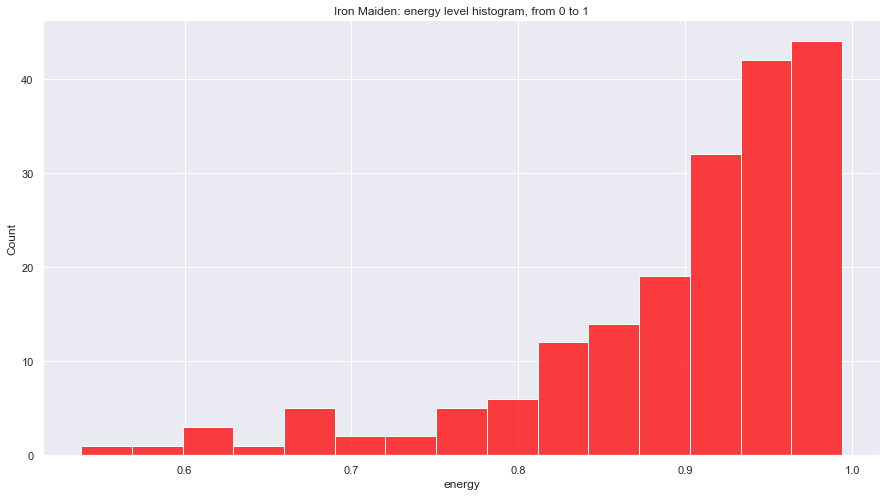

In [30]:
#energy histogram
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=maiden_final, x = 'energy', color='red').set(title='Iron Maiden: energy level histogram, from 0 to 1')
plt.savefig('energy_histogram.png')

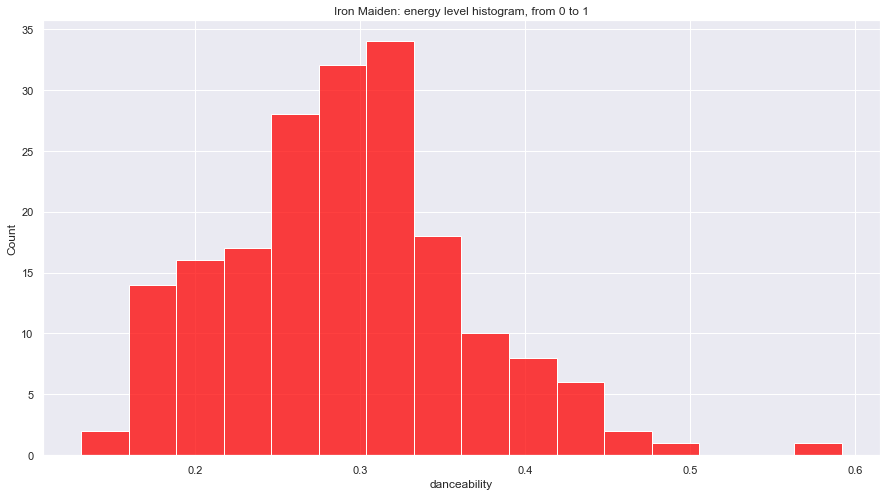

In [31]:
#danceability histogram
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=maiden_final, x = 'danceability', color='red').set(title='Iron Maiden: energy level histogram, from 0 to 1')
plt.savefig('danceability_histogram.png')

In [32]:
maiden_final.sort_values('danceability', ascending=False)

,name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year,simple_name,uniques
595,The Apparition,40,1992-01-01,0.6930,0.592,0.929,9,-4.281,1,0.0378,0.000985,0.000095,0.0777,98.092,234787,1992,The Apparition,the apparition
785,Running Free,52,1980-01-01,0.7640,0.478,0.823,11,-5.346,0,0.2060,0.000777,0.229000,0.1690,171.263,197573,1980,Running Free,running free
11,Stratego,57,2021-09-03,0.4650,0.473,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946,2021,Stratego,stratego
668,Alexander the Great (356,52,1986-01-01,0.2880,0.454,0.944,4,-5.003,0,0.0849,0.084000,0.011900,0.1100,113.321,517093,1986,Alexander the Great (356,alexander the great (356
714,2 Minutes to Midnight,66,1984-01-01,0.5950,0.446,0.970,9,-5.004,0,0.0508,0.007540,0.000275,0.1990,94.233,363587,1984,2 Minutes to Midnight,2 minutes to midnight
104,The Man of Sorrows,38,2015-09-04,0.2910,0.441,0.780,2,-5.488,0,0.0418,0.024200,0.000063,0.2300,110.180,387543,2015,The Man of Sorrows,the man of sorrows
747,Invaders,48,1982-01-01,0.6840,0.439,0.937,4,-5.410,0,0.0493,0.017500,0.025200,0.4960,111.794,203387,1982,Invaders,invaders
766,Wrathchild,52,1981-01-01,0.7820,0.438,0.930,9,-4.959,1,0.0484,0.018800,0.349000,0.1960,104.812,175053,1981,Wrathchild,wrathchild
14,Days Of Future Past,59,2021-09-03,0.4760,0.433,0.920,4,-4.738,0,0.0409,0.000576,0.000055,0.1230,92.466,243755,2021,Days Of Future Past,days of future past
447,The Wicker Man,59,2000-01-01,0.2960,0.424,0.980,4,-4.330,0,0.1540,0.000855,0.000006,0.1290,101.502,275253,2000,The Wicker Man,the wicker man


In [33]:
# valence vs years
maiden_years = maiden_final[["name", "valence", 'year']]

maiden_years.to_csv('years_valence.csv', index=False)



In [34]:
# danceability
maiden_danceability = maiden_final[["name", "danceability"]]

maiden_danceability = maiden_danceability.sort_values('danceability', ascending=False)

maiden_danceability.to_csv('danceability.csv', index=False)

In [35]:
# danceability
maiden_danceability_years = maiden_final[["name", "danceability", 'year']]

maiden_danceability_years.to_csv('danceability_years.csv', index=False)

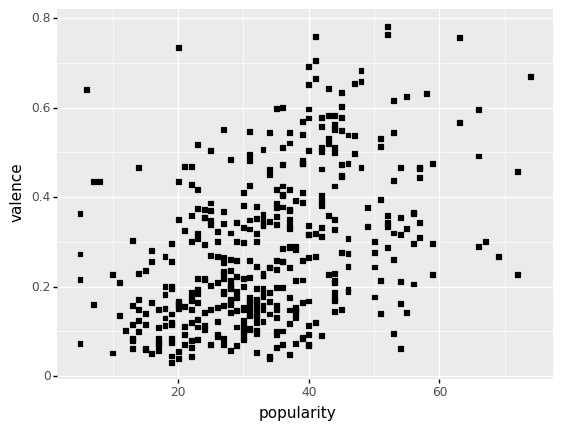

<ggplot: (380465990)>

In [36]:
(
    ggplot(final_df,          # data
        aes('popularity', 'valence')) # aesthetics
        + geom_point(shape = 's')      # geometry
)

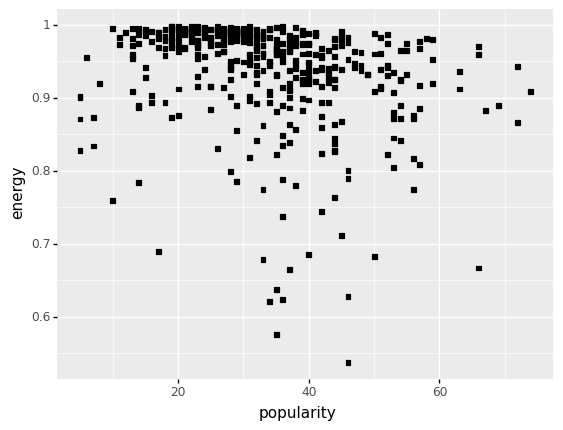

<ggplot: (380371101)>

In [37]:
(
    ggplot(final_df,          # data
        aes('popularity', 'energy')) # aesthetics
        + geom_point(shape = 's')      # geometry
)

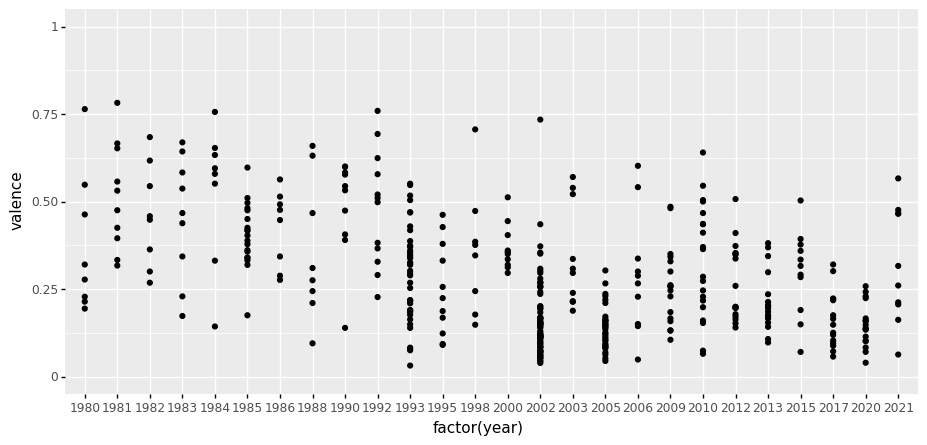

<ggplot: (380523487)>

In [39]:
#Valence per year

(
    ggplot(final_df)
    + aes(x='factor(year)', y='valence')
    + geom_point()
    + coord_cartesian(ylim=(0, 1))
    + theme(figure_size=(11, 5)) # set chart dimensions
)

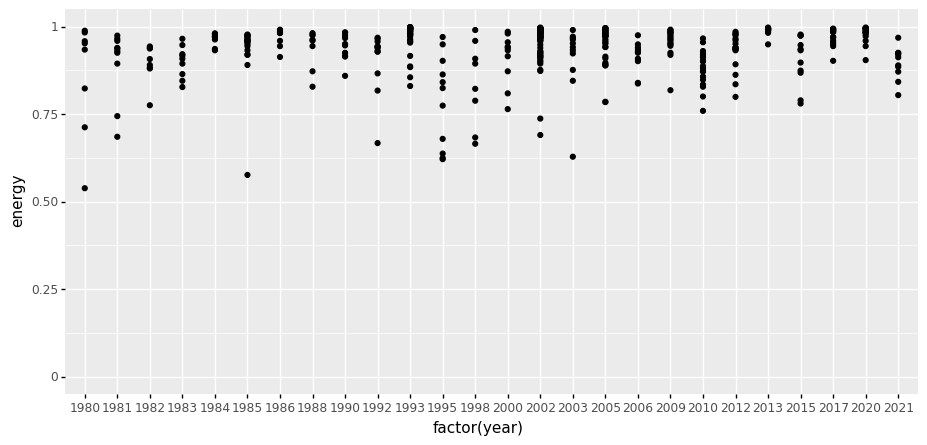

<ggplot: (380590933)>

In [40]:
#Valence per year

(
    ggplot(final_df)
    + aes(x='factor(year)', y='energy')
    + geom_point()
    + coord_cartesian(ylim=(0, 1))
    + theme(figure_size=(11, 5)) # set chart dimensions
)

## Let's check Iron Maiden's average setlist for 2019 (I didn't find anything after 2019). It is displayed [here](https://www.setlist.fm/stats/average-setlist/iron-maiden-3bd6803c.html?year=2019)

These are the songs that we will analyze:
Aces High, Where Eagles Dare, 2 Minutes to Midnight, The Clansman, The Trooper, Revelations
For the Greater Good of God, The Wicker Man, Sign of the Cross, Flight of Icarus, Fear of the Dark
The Number of the Beast, Iron Maiden, The Evil That Men Do, Hallowed Be Thy Name, Run to the Hills

In [41]:
avg_concert = [
'Aces High', 
'Where Eagles Dare', 
'2 Minutes to Midnight', 
'The Clansman', 
'The Trooper', 
'Revelations'
'For the Greater Good of God', 
'The Wicker Man', 
'Sign of the Cross', 
'Flight of Icarus', 
'Fear of the Dark',
'The Number of the Beast',
'Iron Maiden', 
'The Evil That Men Do', 
'Hallowed Be Thy Name', 
'Run to the Hills'
]

avg_concert[-1]

'Run to the Hills'

In [42]:
final_df.name.unique()

array(['Senjutsu', 'Stratego', 'The Writing On The Wall',
       'Lost In A Lost World', 'Days Of Future Past', 'The Time Machine',
       'Darkest Hour', 'Death Of The Celts', 'The Parchment',
       'Hell On Earth',
       'Churchill’s Speech - Live in Mexico City, Palacio de los Deportes, Mexico, September 2019',
       'Aces High - Live in Mexico City, Palacio de los Deportes, Mexico, September 2019',
       'Where Eagles Dare - Live in Mexico City, Palacio de los Deportes, Mexico, September 2019',
       '2 Minutes To Midnight - Live in Mexico City, Palacio de los Deportes, Mexico, September 2019',
       'The Clansman - Live in Mexico City, Palacio de los Deportes, Mexico, September 2019',
       'The Trooper - Live in Mexico City, Palacio de los Deportes, Mexico, September 2019',
       'Revelations - Live in Mexico City, Palacio de los Deportes, Mexico, September 2019',
       'For The Greater Good Of God - Live in Mexico City, Palacio de los Deportes, Mexico, September 2019',


In [43]:
avg_setlist_list = ['2 Minutes to Midnight - 2015 Remaster','The Clansman - 2015 Remaster', 
'The Trooper - 2015 Remaster', 
'Revelations - 2015 Remaster'
'For the Greater Good of God - 2015 Remaster', 
'The Wicker Man - 2015 Remaster', 
'Sign of the Cross - Live at Rock in Rio; 2015 Remastered Version', 
'Flight of Icarus - 2015 Remaster', 
'Fear of the Dark - 2015 Remaster',
'The Number of the Beast - 2015 Remaster',
'Iron Maiden - 2015 Remaster', 
'The Evil That Men Do - 2015 Remaster', 
'Hallowed Be Thy Name - 2015 Remaster', 
'Run to the Hills - 2015 Remaster']

In [44]:
avg_setlist = {
    
1: '2 Minutes to Midnight - 2015 Remaster',
2: 'The Clansman - 2015 Remaster', 
3: 'The Trooper - 2015 Remaster', 
4: 'Revelations - 2015 Remaster',
5: 'For the Greater Good of God - 2015 Remaster', 
6: 'The Wicker Man - 2015 Remaster', 
7: 'Sign of the Cross - Live at Rock in Rio; 2015 Remastered Version', 
8: 'Flight of Icarus - 2015 Remaster', 
9: 'Fear of the Dark - 2015 Remaster',
10: 'The Number of the Beast - 2015 Remaster',
11: 'Iron Maiden - 2015 Remaster', 
12: 'The Evil That Men Do - 2015 Remaster', 
13: 'Hallowed Be Thy Name - 2015 Remaster', 
14: 'Run to the Hills - 2015 Remaster'
    
}

avg_setlist

{1: '2 Minutes to Midnight - 2015 Remaster',
 2: 'The Clansman - 2015 Remaster',
 3: 'The Trooper - 2015 Remaster',
 4: 'Revelations - 2015 Remaster',
 5: 'For the Greater Good of God - 2015 Remaster',
 6: 'The Wicker Man - 2015 Remaster',
 7: 'Sign of the Cross - Live at Rock in Rio; 2015 Remastered Version',
 8: 'Flight of Icarus - 2015 Remaster',
 9: 'Fear of the Dark - 2015 Remaster',
 10: 'The Number of the Beast - 2015 Remaster',
 11: 'Iron Maiden - 2015 Remaster',
 12: 'The Evil That Men Do - 2015 Remaster',
 13: 'Hallowed Be Thy Name - 2015 Remaster',
 14: 'Run to the Hills - 2015 Remaster'}

In [45]:
concert_dataframe = pd.DataFrame(avg_setlist.items(), columns=['Sequence', 'Song'])
concert_dataframe

,Sequence,Song
0,1,2 Minutes to Midnight - 2015 Remaster
1,2,The Clansman - 2015 Remaster
2,3,The Trooper - 2015 Remaster
3,4,Revelations - 2015 Remaster
4,5,For the Greater Good of God - 2015 Remaster
5,6,The Wicker Man - 2015 Remaster
6,7,Sign of the Cross - Live at Rock in Rio; 2015 ...
7,8,Flight of Icarus - 2015 Remaster
8,9,Fear of the Dark - 2015 Remaster
9,10,The Number of the Beast - 2015 Remaster


In [46]:
concert_data = final_df[final_df.name.isin(avg_setlist_list)]
concert_data

,name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year,simple_name
406,Sign of the Cross - Live at Rock in Rio; 2015 ...,23,2002-03-21,0.110,0.225,0.915,0,-7.260,1,0.0884,0.007180,0.211000,0.9270,110.950,650496,2002,Sign of the Cross
447,The Wicker Man - 2015 Remaster,59,2000-01-01,0.296,0.424,0.980,4,-4.330,0,0.1540,0.000855,0.000006,0.1290,101.502,275253,2000,The Wicker Man
468,The Clansman - 2015 Remaster,50,1998-01-01,0.177,0.257,0.683,2,-6.670,1,0.0495,0.150000,0.011100,0.1160,154.106,539787,1998,The Clansman
598,Fear of the Dark - 2015 Remaster,72,1992-01-01,0.227,0.308,0.866,2,-5.671,0,0.0590,0.000739,0.001410,0.2320,109.825,438120,1992,Fear of the Dark
648,The Evil That Men Do - 2015 Remaster,57,1988-01-01,0.310,0.255,0.977,4,-4.672,0,0.1100,0.008520,0.000003,0.0776,161.738,274213,1988,The Evil That Men Do
714,2 Minutes to Midnight - 2015 Remaster,66,1984-01-01,0.595,0.446,0.970,9,-5.004,0,0.0508,0.007540,0.000275,0.1990,94.233,363587,1984,2 Minutes to Midnight
732,Flight of Icarus - 2015 Remaster,57,1983-01-01,0.343,0.368,0.917,6,-4.829,0,0.0772,0.147000,0.000121,0.1690,110.455,230760,1983,Flight of Icarus
734,The Trooper - 2015 Remaster,74,1983-01-01,0.669,0.285,0.908,4,-4.601,0,0.0705,0.031800,0.009090,0.3110,159.756,252733,1983,The Trooper
751,The Number of the Beast - 2015 Remaster,69,1982-01-01,0.268,0.409,0.890,0,-6.839,1,0.0558,0.088000,0.107000,0.0935,100.409,290587,1982,The Number of the Beast
752,Run to the Hills - 2015 Remaster,72,1982-01-01,0.458,0.249,0.943,0,-5.188,1,0.0669,0.028600,0.004010,0.1620,173.671,233507,1982,Run to the Hills


In [47]:
merged = concert_data.merge(concert_dataframe, how='left', left_on='name', right_on='Song')
final_concert = merged.drop(columns = 'Song')
final_concert.sort_values('Sequence')

final_concert.to_csv('concert.csv', index=False)


In [48]:
# transform microseconds into minutes
final_concert.duration_ms = final_concert.duration_ms / 60000
final_concert

,name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year,simple_name,Sequence
0,Sign of the Cross - Live at Rock in Rio; 2015 ...,23,2002-03-21,0.110,0.225,0.915,0,-7.260,1,0.0884,0.007180,0.211000,0.9270,110.950,10.841600,2002,Sign of the Cross,7
1,The Wicker Man - 2015 Remaster,59,2000-01-01,0.296,0.424,0.980,4,-4.330,0,0.1540,0.000855,0.000006,0.1290,101.502,4.587550,2000,The Wicker Man,6
2,The Clansman - 2015 Remaster,50,1998-01-01,0.177,0.257,0.683,2,-6.670,1,0.0495,0.150000,0.011100,0.1160,154.106,8.996450,1998,The Clansman,2
3,Fear of the Dark - 2015 Remaster,72,1992-01-01,0.227,0.308,0.866,2,-5.671,0,0.0590,0.000739,0.001410,0.2320,109.825,7.302000,1992,Fear of the Dark,9
4,The Evil That Men Do - 2015 Remaster,57,1988-01-01,0.310,0.255,0.977,4,-4.672,0,0.1100,0.008520,0.000003,0.0776,161.738,4.570217,1988,The Evil That Men Do,12
5,2 Minutes to Midnight - 2015 Remaster,66,1984-01-01,0.595,0.446,0.970,9,-5.004,0,0.0508,0.007540,0.000275,0.1990,94.233,6.059783,1984,2 Minutes to Midnight,1
6,Flight of Icarus - 2015 Remaster,57,1983-01-01,0.343,0.368,0.917,6,-4.829,0,0.0772,0.147000,0.000121,0.1690,110.455,3.846000,1983,Flight of Icarus,8
7,The Trooper - 2015 Remaster,74,1983-01-01,0.669,0.285,0.908,4,-4.601,0,0.0705,0.031800,0.009090,0.3110,159.756,4.212217,1983,The Trooper,3
8,The Number of the Beast - 2015 Remaster,69,1982-01-01,0.268,0.409,0.890,0,-6.839,1,0.0558,0.088000,0.107000,0.0935,100.409,4.843117,1982,The Number of the Beast,10
9,Run to the Hills - 2015 Remaster,72,1982-01-01,0.458,0.249,0.943,0,-5.188,1,0.0669,0.028600,0.004010,0.1620,173.671,3.891783,1982,Run to the Hills,14


In [49]:
final_concert.columns

Index(['name', 'popularity', 'release_date', 'valence', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'year',
       'simple_name', 'Sequence'],
      dtype='object')

In [50]:
final_concert.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              12 non-null     object        
 1   popularity        12 non-null     int64         
 2   release_date      12 non-null     datetime64[ns]
 3   valence           12 non-null     float64       
 4   danceability      12 non-null     float64       
 5   energy            12 non-null     float64       
 6   key               12 non-null     int64         
 7   loudness          12 non-null     float64       
 8   mode              12 non-null     int64         
 9   speechiness       12 non-null     float64       
 10  acousticness      12 non-null     float64       
 11  instrumentalness  12 non-null     float64       
 12  liveness          12 non-null     float64       
 13  tempo             12 non-null     float64       
 14  duration_ms       12 non-nul

In [51]:
df.sort_values('danceability', ascending=False)

,name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms
563,The Apparition - 2015 Remaster,26,1992-05-11,0.6930,0.5920,0.929,9,-4.281,1,0.0378,0.000985,0.000095,0.0777,98.092,234787
595,The Apparition - 2015 Remaster,40,1992,0.6930,0.5920,0.929,9,-4.281,1,0.0378,0.000985,0.000095,0.0777,98.092,234787
785,Running Free - 2015 Remaster,52,1980,0.7640,0.4780,0.823,11,-5.346,0,0.2060,0.000777,0.229000,0.1690,171.263,197573
777,Running Free - 2015 Remaster,42,1980-04-14,0.7640,0.4780,0.823,11,-5.346,0,0.2060,0.000777,0.229000,0.1690,171.263,197573
11,Stratego,57,2021-09-03,0.4650,0.4730,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946
1,Stratego,44,2021-09-03,0.4650,0.4730,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946
700,Wrathchild - Live at the Hammersmith Odeon; 19...,35,1985,0.3570,0.4660,0.968,0,-9.423,1,0.0499,0.002040,0.887000,0.9760,103.989,184133
682,Wrathchild - Live at the Hammersmith Odeon; 19...,25,1985-10-14,0.3650,0.4540,0.975,4,-9.397,0,0.0497,0.001890,0.863000,0.9910,103.947,185707
660,Alexander the Great (356-323 B.C.) - 2015 Rema...,40,1986-09-29,0.2880,0.4540,0.944,4,-5.003,0,0.0849,0.084000,0.011900,0.1100,113.321,517093
668,Alexander the Great (356-323 B.C.) - 2015 Rema...,52,1986,0.2880,0.4540,0.944,4,-5.003,0,0.0849,0.084000,0.011900,0.1100,113.321,517093
